In [1]:
'''
Derivative + cosine annealing from MAML++
Note, here, we replace FOMAML with Reptile
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings
import importlib

warnings.filterwarnings("ignore")

#Set random seeds for reproducibility of results 
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

# import backbone model, dataset, and code utils
from models import Neural_Network
from constants import *
from utils import *
import analysis_utils
from data import *

Available device: cpu
Available device: cpu


In [2]:
'''
Create dataset
'''
# specify the number of tasks to sample per meta-set
# note: we end up sampling tasks at random, so sizes are not particularly relevant
# artifact of the way we structured the dataset earlier 
meta_train_size=10000
meta_val_size=1000
meta_test_size=1000
meta_train_eval_size = 20

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

In [3]:
'''
Main training loop

Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''

#Instantiate the model network
model = Neural_Network()
# move to the current device (GPU or CPU)
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
model.to(device)

N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
K = 10 # number of samples to draw from the task
min_lr_meta = .0001 #minimum learning rate for the meta optimizer 

#Used to store the validation losses
metaLosses = []
metaValLosses = []

#Meta-optimizer for the outer loop
meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)
    
cosScheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=meta_optimizer, T_max=num_epochs,
                   eta_min=0, verbose = False)

#Inner optimizer, we were doing this by hand previously
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)



'''
Sample of how to use the classes
'''

k = 5 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
lr_meta_reptile = 0.001 # meta-update learning rate
lr_k_reptile = .01
num_epochs_reptile = 2500 #70001 #Number of iterations for outer loop
printing_step_reptile = 500 # show log of loss every x epochs
meta_optimizer_reptile = torch.optim.Adam(model.parameters(), lr=lr_meta_reptile)

criterion = nn.MSELoss()


for epoch in range(num_epochs_reptile):
    
    waves = dataset.get_meta_train_batch(task_batch_size=1)
    
    new_model, meta_loss = training_reptile(model, waves[0], criterion, lr_k_reptile, k)
    metaLosses.append(meta_loss.item())
    
    metaupdate(model,new_model,meta_optimizer_reptile)
    
    val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
    
    val_loss = test_set_validation(model,new_model,val_wave,criterion,lr_k_reptile,k)
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step_reptile == 0:
        print("Reptile Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), "backup_data/reptile_da_model.pt")


for epoch in range(num_epochs):
    cosScheduler.step(epoch=epoch)
    # store loss over all tasks to then do a large meta-level update of initial params
    # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
    meta_loss = None
    
    #Sample a new wave each time
    waves = dataset.get_meta_train_batch(task_batch_size=T)
    
    #Loop through all of the tasks
    for i, T_i in enumerate(waves): 
        train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
        held_out_task_specific_loss = train_eval_info[0]
        if meta_loss is None: 
            meta_loss = held_out_task_specific_loss
        else:
            meta_loss += held_out_task_specific_loss
            
    meta_optimizer.zero_grad()
    meta_loss /= T
    meta_loss.backward()
    meta_optimizer.step()
    metaLosses.append(meta_loss.item())
    
    # validation 
    val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
    val_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
    val_loss=val_eval_info[0]
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step == 0:
        print("MAML Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), "backup_data/maml_da_model.pt")

Reptile Iter =  0  Current Loss 0.7727006673812866  Val Loss:  20.614574432373047
Reptile Iter =  500  Current Loss 3.6266273478737863  Val Loss:  3.2069316460536377
Reptile Iter =  1000  Current Loss 3.32192330433692  Val Loss:  2.953113012606704
Reptile Iter =  1500  Current Loss 3.1559746260083816  Val Loss:  2.9366443950651475
Reptile Iter =  2000  Current Loss 3.1004043967966473  Val Loss:  2.8908937046995566
MAML Iter =  0  Current Loss 3.110223790733339  Val Loss:  2.798072363206933
MAML Iter =  500  Current Loss 2.9627575211750905  Val Loss:  2.6978825843323087
MAML Iter =  1000  Current Loss 2.7541517487975393  Val Loss:  2.4947458134855736
MAML Iter =  1500  Current Loss 2.5454249950509036  Val Loss:  2.3156855054602534
MAML Iter =  2000  Current Loss 2.355545800928612  Val Loss:  2.1452702863794215
MAML Iter =  2500  Current Loss 2.192532329422806  Val Loss:  1.9971672263695832
MAML Iter =  3000  Current Loss 2.0520456665227242  Val Loss:  1.8647355627423565
MAML Iter =  350

Step: 0, Error: 3.0178774673910813, Var: 5.7114881349904945
Step: 1, Error: 0.319833796847146, Var: 0.0707601953782532
Step: 5, Error: 0.04498379230464343, Var: 0.01419622615001988


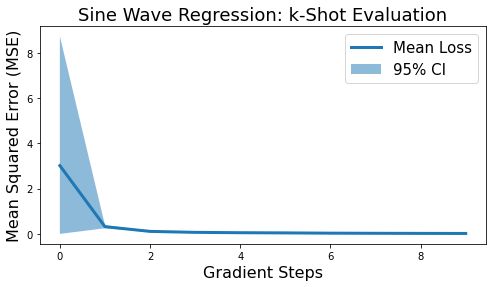

In [6]:
importlib.reload(analysis_utils)

num_k_shots = 10
K = 10
num_eval=1000
file_tag = "derivative_annealing_unidim"

res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                        file_tag=file_tag)

In [ ]:
'''
Main training loop --- run w/ just DA!!

Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''

#Instantiate the model network
model = Neural_Network()
# move to the current device (GPU or CPU)
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
model.to(device)

N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
K = 10 # number of samples to draw from the task
min_lr_meta = .0001 #minimum learning rate for the meta optimizer 

#Used to store the validation losses
metaLosses = []
metaValLosses = []

#Meta-optimizer for the outer loop
meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

#Inner optimizer, we were doing this by hand previously
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)



'''
Sample of how to use the classes
'''

k = 5 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
lr_meta_reptile = 0.001 # meta-update learning rate
lr_k_reptile = .01
num_epochs_reptile = 2500 #70001 #Number of iterations for outer loop
printing_step_reptile = 500 # show log of loss every x epochs
meta_optimizer_reptile = torch.optim.Adam(model.parameters(), lr=lr_meta_reptile)

criterion = nn.MSELoss()


for epoch in range(num_epochs_reptile):
    
    waves = dataset.get_meta_train_batch(task_batch_size=1)
    
    new_model, meta_loss = training_reptile(model, waves[0], criterion, lr_k_reptile, k)
    metaLosses.append(meta_loss.item())
    
    metaupdate(model,new_model,meta_optimizer_reptile)
    
    val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
    
    val_loss = test_set_validation(model,new_model,val_wave,criterion,lr_k_reptile,k)
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step_reptile == 0:
        print("Reptile Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), "backup_data/reptile_da_only_model.pt")


for epoch in range(num_epochs):
    # store loss over all tasks to then do a large meta-level update of initial params
    # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
    meta_loss = None
    
    #Sample a new wave each time
    waves = dataset.get_meta_train_batch(task_batch_size=T)
    
    #Loop through all of the tasks
    for i, T_i in enumerate(waves): 
        train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
        held_out_task_specific_loss = train_eval_info[0]
        if meta_loss is None: 
            meta_loss = held_out_task_specific_loss
        else:
            meta_loss += held_out_task_specific_loss
            
    meta_optimizer.zero_grad()
    meta_loss /= T
    meta_loss.backward()
    meta_optimizer.step()
    metaLosses.append(meta_loss.item())
    
    # validation 
    val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
    val_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
    val_loss=val_eval_info[0]
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step == 0:
        print("MAML Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), "backup_data/maml_da_only_model.pt")

Reptile Iter =  0  Current Loss 8.404191017150879  Val Loss:  2.138186454772949
Reptile Iter =  500  Current Loss 4.0521035872870925  Val Loss:  3.157861019040074
Reptile Iter =  1000  Current Loss 3.4833531957206953  Val Loss:  3.0154320136376405
Reptile Iter =  1500  Current Loss 3.3722086444143424  Val Loss:  2.9675254756609433
Reptile Iter =  2000  Current Loss 3.2985631785313156  Val Loss:  2.9523129018854513
MAML Iter =  0  Current Loss 3.221447347610118  Val Loss:  2.8881680524783526
MAML Iter =  500  Current Loss 2.998992838741353  Val Loss:  2.6925569842835713
MAML Iter =  1000  Current Loss 2.735289250869483  Val Loss:  2.4600737181513357
MAML Iter =  1500  Current Loss 2.503446376287776  Val Loss:  2.2599910488911465
MAML Iter =  2000  Current Loss 2.3140240203853364  Val Loss:  2.082990241638248
MAML Iter =  2500  Current Loss 2.1548156720127944  Val Loss:  1.9468436097380162
MAML Iter =  3000  Current Loss 2.0191686387419265  Val Loss:  1.825914414494025
MAML Iter =  3500 

In [ ]:
importlib.reload(analysis_utils)

num_k_shots = 10
K = 10
num_eval=1000
file_tag = "derivative_annealing_only_unidim"

res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                        file_tag=file_tag)

In [ ]:
'''
Main training loop --- run w/ just CA!!

Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''

#Instantiate the model network
model = Neural_Network()
# move to the current device (GPU or CPU)
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
model.to(device)

N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
K = 10 # number of samples to draw from the task
min_lr_meta = .0001 #minimum learning rate for the meta optimizer 

#Used to store the validation losses
metaLosses = []
metaValLosses = []

#Meta-optimizer for the outer loop
meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

#Inner optimizer, we were doing this by hand previously
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

criterion = nn.MSELoss()

for epoch in range(num_epochs):
    # store loss over all tasks to then do a large meta-level update of initial params
    # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
    meta_loss = None
    
    #Sample a new wave each time
    waves = dataset.get_meta_train_batch(task_batch_size=T)
    
    #Loop through all of the tasks
    for i, T_i in enumerate(waves): 
        train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
        held_out_task_specific_loss = train_eval_info[0]
        if meta_loss is None: 
            meta_loss = held_out_task_specific_loss
        else:
            meta_loss += held_out_task_specific_loss
            
    meta_optimizer.zero_grad()
    meta_loss /= T
    meta_loss.backward()
    meta_optimizer.step()
    metaLosses.append(meta_loss.item())
    
    # validation 
    val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
    val_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
    val_loss=val_eval_info[0]
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step == 0:
        print("MAML Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), "backup_data/maml_ca_only_model.pt")

In [ ]:
importlib.reload(analysis_utils)

num_k_shots = 10
K = 10
num_eval=1000
file_tag = "cosine_annealing_only_unidim"

res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                        file_tag=file_tag)